In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adp-kr-p2/problem2.csv
/kaggle/input/adp-kr-p2/problem3.csv
/kaggle/input/adp-kr-p2/problem1.csv
/kaggle/input/adp-kr-p2/problem2_Example.png
/kaggle/input/adp-kr-p2/problem2.png


In [21]:
# 문제는 https://didalsgur.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D%EC%A0%84%EB%AC%B8%EA%B0%80-ADP-20%ED%9A%8C-%EC%8B%A4%EA%B8%B0%EC%8B%9C%ED%97%98-%ED%9B%84%EA%B8%B0
# 참고했습니다


# 1번
날씨 온도 예측, 종속변수 :actual(최고온도)   
데이터 출처 : https://towardsdatascience.com/random-forest-in-python-24d0893d51c0     
데이터 경로 : /kaggle/input/adp-kr-p2/problem1.csv    
temp_1 : 전날 최고온도    
temp_2 : 전전날 최고온도    
friend : 친구의 예측온도     



### 1-1 데이터 확인 및 전처리
- 데이터 EDA 수행     
- 결측치를 확인하고 처리 방안에 대해 논의하라  
- 데이터 분할 방법 설명     
- 최종 데이터셋이 적절함을 주장하라     

In [22]:
df1 = pd.read_csv('/kaggle/input/adp-kr-p2/problem1.csv')
df1.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [23]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [24]:
# date 컬럼 생성
cols = ['year', 'month', 'day']
df1['date'] =df1[cols].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
df1['date'] = pd.to_datetime(df1['date'])
df1.drop(columns = cols, inplace=True)
df1.drop(columns = 'week', axis=1, inplace=True)
df1.head()

,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,date
0,45,45,45.6,45,43,50,44,29,2016-01-01
1,44,45,45.7,44,41,50,44,61,2016-01-02
2,45,44,45.8,41,43,46,47,56,2016-01-03
3,44,41,45.9,40,44,48,46,53,2016-01-04
4,41,40,46.0,44,46,46,46,41,2016-01-05


In [25]:
# 결측치 확인
df1.isna().sum()

temp_2            0
temp_1            0
average           0
actual            0
forecast_noaa     0
forecast_acc      0
forecast_under    0
friend            0
date              0
dtype: int64

데이터셋에 결측치는 존재하지 않음

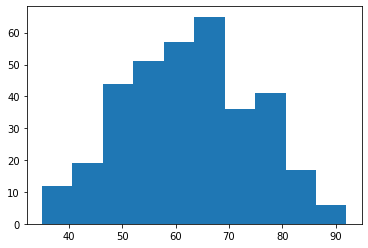

In [26]:
# 종속변수 시각화
import matplotlib.pyplot as plt

plt.hist('actual', data=df1)
plt.show()

종속변수가 대략적으로 정규분포의 형태를 띄고 있음

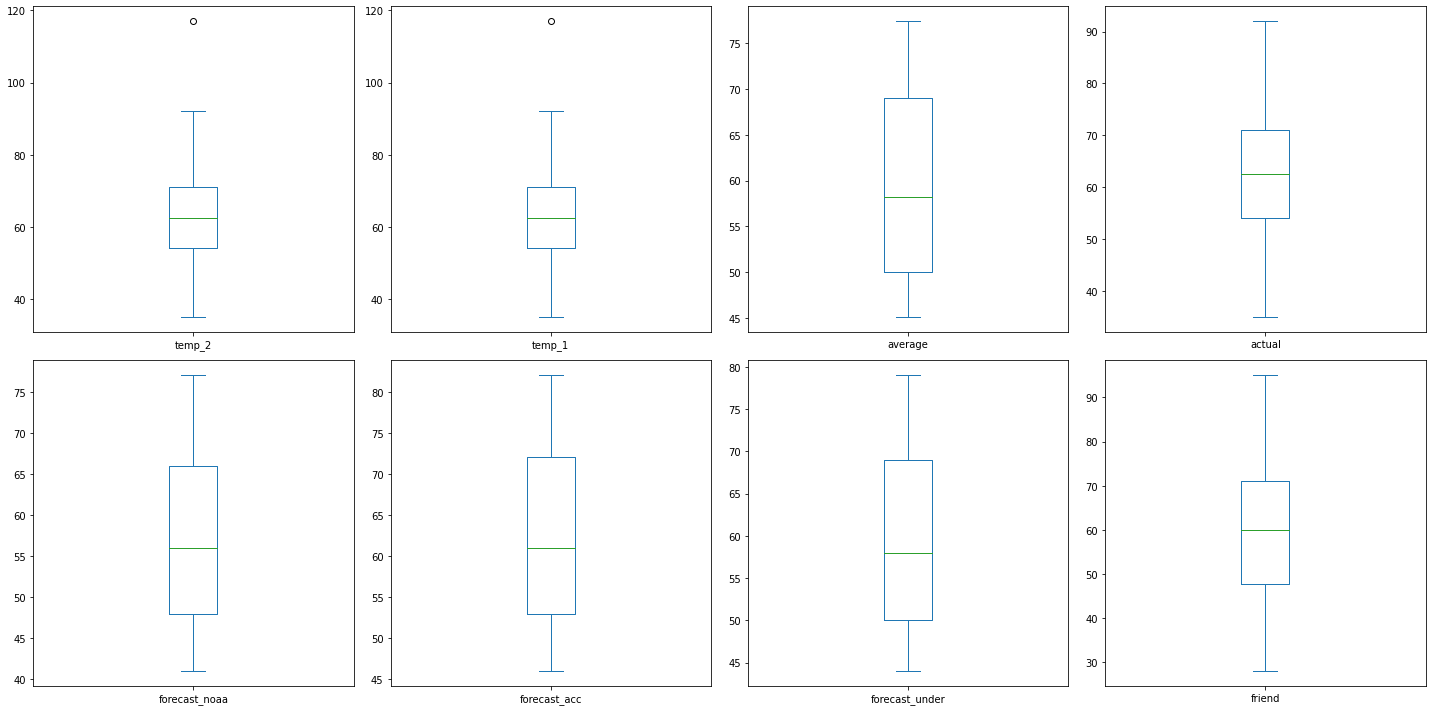

In [27]:
df1.drop(columns='date').plot(kind = 'box', subplots = True, layout = (2,4), figsize=(20,10))
plt.tight_layout()
plt.show()

눈에 띄는 이상치는 존재하지 않음

In [28]:
# 친구의 예측치인 friend, date변수는 예측에 무의미한 변수라고 판단하여 삭제처리
df1.drop(columns=['friend', 'date'], inplace=True)

<AxesSubplot:>

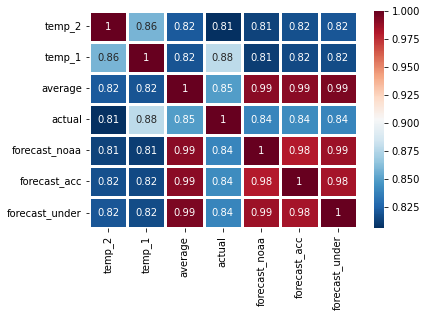

In [30]:
# 상관관계 시각화
import seaborn as sns
sns.heatmap(df1.corr(), xticklabels = df1.columns, yticklabels= df1.columns, cmap='RdBu_r', annot=True, linewidth=3)

거의 모든 변수에 상관관계가 존재함

In [31]:
from sklearn.model_selection import train_test_split

X = df1.drop(columns=['actual'])
y = df1['actual']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(278, 6) (70, 6)
(278,) (70,)


train/test 비율을 8:2로 설정하여 분석을 진행

### 1-2 Random Forest 모델 적합 및 검증   
- Random Forest 학습 및 예측 결과 해석    
- 예측 결과 검정 해석, 중요변수 도출    
- 변수 중요성 분석 및 그래프 출력     

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time

start = time.time()
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print('time : ', (time.time() - start))

rf_pred = rf.predict(X_test)
print('RandomForest RMSE : ', np.sqrt(mean_squared_error(y_test, rf_pred)))

time :  0.20140600204467773
RandomForest RMSE :  5.137097846616734


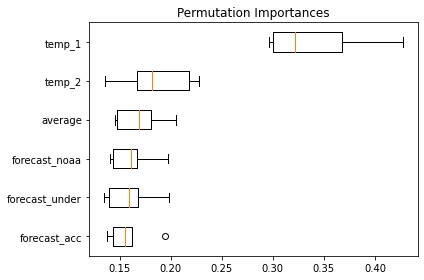

In [63]:
from sklearn.inspection import permutation_importance
import seaborn as sns

def plot_permutation_importance(model):
    
    result = permutation_importance(svr, X_test, y_test, random_state=0)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
              vert = False, labels = X_test.columns[sorted_idx])
    ax.set_title('Permutation Importances')
    fig.tight_layout()
    plt.show()
    
plot_permutation_importance(rf)

RandomForest의 변수 중요도는 temp_1, 2 순서대로 나타났다.

### 1-3 SVM(Support Vector Machine) 모델 적합 및 검증  
- svm 학습 및 예측 결과 해석    
- 예측 결과 검정 해석, 중요변수 도출    
- 변수 중요성 분석 및 그래프 출력     

In [66]:
from sklearn.inspection import permutation_importance

start = time.time()
svr = SVR()
svr.fit(X_train, y_train)
print('Time : ', (time.time() - start))

svr_pred = svr.predict(X_test)

print('SVR RMSE : ', np.sqrt(mean_squared_error(y_test, svr_pred)))

Time :  0.008876323699951172
SVR RMSE :  5.815952335709515


svm 모델의 RMSE 값은 5.82로 RandomForest보다 RMSE 값이 큰 것을 확인

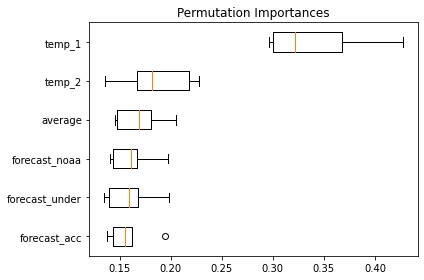

In [64]:
plot_permutation_importance(svr)

RandomForest와 동일하게 temp_1,2 순으로 변수 중요도가 높은 것을 확인했다.

### 1-4 모델 비교 및 향후 개선 방향 도출
- Random Forest, SVM 모델의 결과 비교 후 최종 모델 선택    
- 두 모델의 장단점 분석, 추후 운영 관점에서 어떤 모델을 선택할 것인가?    
- 모델링 관련 추후 개선 방향 제시     

- 모델 예측 결과 RandomForest의 RMSE 값이 5.13, SVM의 RMSE값이 5.82로 랜덤포레스트 모델의 예측 결과가 더 좋게 나타났다. 
- 모델을 학습시키는 데에 걸린 시간은 RandomForest가 0.2, SVM이 0.0008로 학습 속도 측면에서는 SVM모델이 더 우수하게 나타났다.
- 현업에서 두 모델을 사용할 경우, 정확도를 중점으로 모델을 생성하고자하면 RandomForest를, 방대한 양의 데이터를 처리해야 하는 경우에는 SVM 모델을 이용하여 데이터를 학습 시키는 것이 유리해 보인다.
- 추후, 데이터 스케일링과 이상치 제거 후 모델의 예측 정확도를 비교해본다.

# 2번 
5분간격의 가구별 전력 사용량의 데이터    
데이터 출처 : 자체생성    
데이터 경로 : /kaggle/input/adp-kr-p2/problem2.csv    

### 2-1 데이터 전처리
각 가구의 15분간격의 전력량의 합을 구하고 해당데이터를 바탕으로 총 5개의 군집으로 군집화를 진행한 후 아래의 그림과 같은 형태로 출력하라.    
군집화를 위한 데이터 구성의 이유를 설명하라    
(군집 방식에 따라 Cluster컬럼의 값은 달라질수 있음)
![image](https://github.com/Datamanim/datarepo/blob/main/adp/p2/problem2.png?raw=true)

In [254]:
df2 = pd.read_csv('/kaggle/input/adp-kr-p2/problem2.csv')
df2.head()

,houseCode,date,power consumption
0,house_01,2050-01-14 21:00:00,57.559878
1,house_26,2050-01-02 19:10:00,59.726880
2,house_25,2050-01-13 07:20:00,6.558823
3,house_20,2050-01-26 04:55:00,58.514589
4,house_09,2050-01-18 22:50:00,5.717009


In [255]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401760 entries, 0 to 401759
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   houseCode          401760 non-null  object 
 1   date               401760 non-null  object 
 2   power consumption  401760 non-null  float64
dtypes: float64(1), object(2)
memory usage: 9.2+ MB


In [256]:
df2['date'] = pd.to_datetime(df2['date'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401760 entries, 0 to 401759
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   houseCode          401760 non-null  object        
 1   date               401760 non-null  datetime64[ns]
 2   power consumption  401760 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.2+ MB


In [257]:
df2.sort_values(['houseCode','date'],inplace=True)
df2.reset_index(drop=True, inplace=True)
df2

,houseCode,date,power consumption
0,house_00,2050-01-01 00:00:00,58.253938
1,house_00,2050-01-01 00:05:00,21.731130
2,house_00,2050-01-01 00:10:00,56.264884
3,house_00,2050-01-01 00:15:00,27.894691
4,house_00,2050-01-01 00:20:00,24.690939
...,...,...,...
401755,house_44,2050-01-31 23:35:00,44.601616
401756,house_44,2050-01-31 23:40:00,68.985932
401757,house_44,2050-01-31 23:45:00,106.008215
401758,house_44,2050-01-31 23:50:00,45.660078


In [258]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401760 entries, 0 to 401759
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   houseCode          401760 non-null  object        
 1   date               401760 non-null  datetime64[ns]
 2   power consumption  401760 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.2+ MB


In [259]:
df2

,houseCode,date,power consumption
0,house_00,2050-01-01 00:00:00,58.253938
1,house_00,2050-01-01 00:05:00,21.731130
2,house_00,2050-01-01 00:10:00,56.264884
3,house_00,2050-01-01 00:15:00,27.894691
4,house_00,2050-01-01 00:20:00,24.690939
...,...,...,...
401755,house_44,2050-01-31 23:35:00,44.601616
401756,house_44,2050-01-31 23:40:00,68.985932
401757,house_44,2050-01-31 23:45:00,106.008215
401758,house_44,2050-01-31 23:50:00,45.660078


In [266]:
df_group = df2.groupby(['houseCode']).resample(rule='15min',on='date').sum()
df_group.reset_index(inplace=True)
df_group

,houseCode,date,power consumption
0,house_00,2050-01-01 00:00:00,136.249952
1,house_00,2050-01-01 00:15:00,98.283387
2,house_00,2050-01-01 00:30:00,53.967679
3,house_00,2050-01-01 00:45:00,204.821270
4,house_00,2050-01-01 01:00:00,150.760786
...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717
133916,house_44,2050-01-31 23:00:00,463.419892
133917,house_44,2050-01-31 23:15:00,369.930740
133918,house_44,2050-01-31 23:30:00,237.713030


In [268]:
from sklearn.cluster import KMeans

k = 5
km = KMeans(n_clusters=k, random_state = 0)
km.fit(df_group[['power consumption']])
df_group['Cluster'] = km.labels_

df_group

,houseCode,date,power consumption,Cluster
0,house_00,2050-01-01 00:00:00,136.249952,2
1,house_00,2050-01-01 00:15:00,98.283387,2
2,house_00,2050-01-01 00:30:00,53.967679,2
3,house_00,2050-01-01 00:45:00,204.821270,3
4,house_00,2050-01-01 01:00:00,150.760786,3
...,...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717,4
133916,house_44,2050-01-31 23:00:00,463.419892,1
133917,house_44,2050-01-31 23:15:00,369.930740,4
133918,house_44,2050-01-31 23:30:00,237.713030,0


### 2-2 히트맵
2-1의 데이터를 바탕으로 각 군집의 요일, 15분간격별 전력사용량의 합을 구한 후 아래와 같이 시각화 하여라    
(수치는 동일하지 않을 수 있음 2-1의 데이터가 정확하게 아래와 같은 이미지로 변환 됐는지 주로 확인)     
![image](https://github.com/Datamanim/datarepo/blob/main/adp/p2/problem2_Example.png?raw=true)

In [274]:
from time import strftime

df_group2 = df_group.copy()
df_group2['day'] = df_group.date.dt.day_name()
df_group2['time'] = df_group.date.dt.strftime('%H:%M')
df_group2

,houseCode,date,power consumption,Cluster,day,time
0,house_00,2050-01-01 00:00:00,136.249952,2,Saturday,00:00
1,house_00,2050-01-01 00:15:00,98.283387,2,Saturday,00:15
2,house_00,2050-01-01 00:30:00,53.967679,2,Saturday,00:30
3,house_00,2050-01-01 00:45:00,204.821270,3,Saturday,00:45
4,house_00,2050-01-01 01:00:00,150.760786,3,Saturday,01:00
...,...,...,...,...,...,...
133915,house_44,2050-01-31 22:45:00,334.675717,4,Monday,22:45
133916,house_44,2050-01-31 23:00:00,463.419892,1,Monday,23:00
133917,house_44,2050-01-31 23:15:00,369.930740,4,Monday,23:15
133918,house_44,2050-01-31 23:30:00,237.713030,0,Monday,23:30


In [295]:
df_group2 = df_group2.groupby(['Cluster','day','time']).sum(['power consumption'])
df_group2.reset_index(inplace=True)
df_group2

,Cluster,day,time,power consumption
0,0,Friday,00:00,12885.653272
1,0,Friday,00:15,12930.802368
2,0,Friday,00:30,15406.349653
3,0,Friday,00:45,13554.313908
4,0,Friday,01:00,10050.717853
...,...,...,...,...
3355,4,Wednesday,22:45,8803.866657
3356,4,Wednesday,23:00,9619.937644
3357,4,Wednesday,23:15,13818.359636
3358,4,Wednesday,23:30,8034.511487


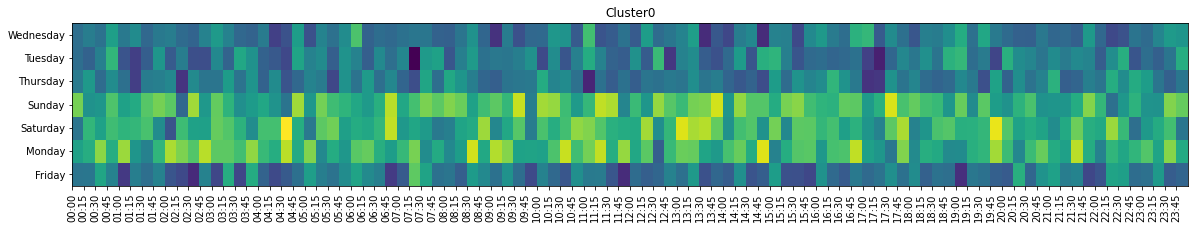

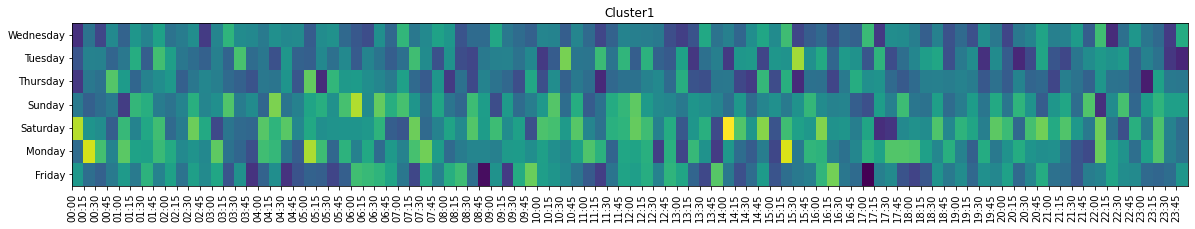

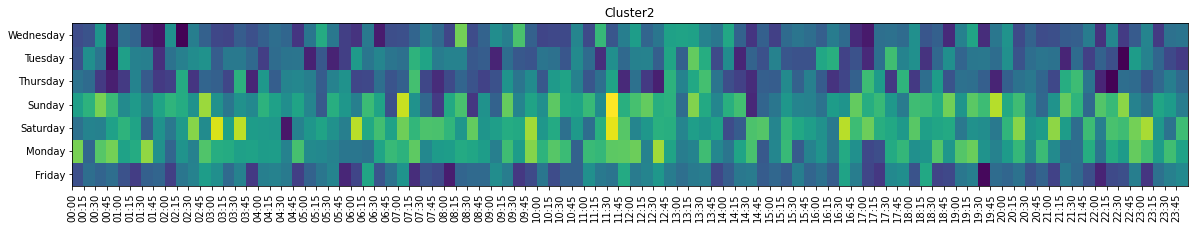

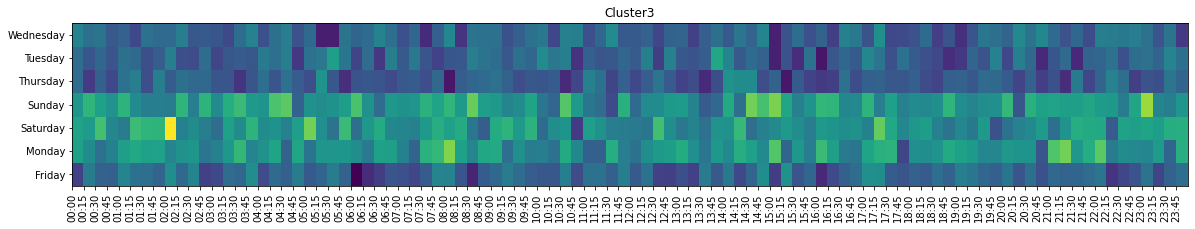

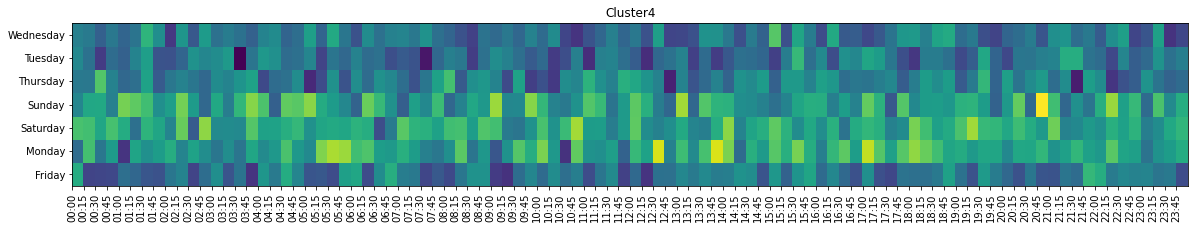

In [302]:
for i in df_group2.Cluster.unique():
    n_df = df_group2[df_group2.Cluster == i]
    pvt = n_df.pivot(index='day', columns = 'time', values = 'power consumption')
    
    plt.figure(figsize = (20,3))
    plt.pcolor(pvt)
    plt.title('Cluster'+str(i))
    plt.xticks(range(len(pvt.columns)), pvt.columns, rotation = 90)
    plt.yticks(np.arange(len(pvt.index))+0.5, pvt.index)

# 3번 태양광 데이터
예측 변수 :SOLAR PV


데이터 경로 : /kaggle/input/adp-kr-p2/problem3.csv    
데이터 출처 : https://www.kaggle.com/cheedcheed/california-renewable-production-20102018

### 3-1
**데이터셋 분할 및 결과 검증**    
- 데이터셋 7:3 분할    
- 데이터 전처리 및 예측 모델 생성    
- 모델 성능 검증 : RMSE, R제곱, 정확도(아래 방식으로 연산)로 구하여라    
- 정확도의 경우 실제값>예측값인 경우 (1-예측값/실제값), 실제값<예측값인 경우 (1- 실제값/예측값)으로 하고 이것들을 평균낸 후 1에서 뺀값으로 한다.   
  분수식의 분모가 0인 경우의 정확도는 0.5로 취급한다.

- 최종 결과 제출 : 소수점 3째자리 반올림     

In [303]:
df3 = pd.read_csv('/kaggle/input/adp-kr-p2/problem3.csv')
df3.head()

,TIMESTAMP,BIOGAS,BIOMASS,GEOTHERMAL,Hour,SMALL HYDRO,SOLAR,SOLAR PV,SOLAR THERMAL,WIND TOTAL
0,2012-11-26 00:00:00,208.0,354.0,926.0,1.0,208.0,NaN,0.0,0.0,57.0
1,2012-11-26 01:00:00,207.0,354.0,927.0,2.0,207.0,NaN,0.0,0.0,76.0
2,2012-11-26 02:00:00,208.0,353.0,927.0,3.0,208.0,NaN,0.0,0.0,100.0
3,2012-11-26 03:00:00,208.0,350.0,927.0,4.0,209.0,NaN,0.0,0.0,111.0
4,2012-11-26 04:00:00,209.0,352.0,927.0,5.0,209.0,NaN,0.0,0.0,131.0


In [305]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44904 entries, 0 to 44903
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TIMESTAMP      44904 non-null  object 
 1   BIOGAS         44904 non-null  float64
 2   BIOMASS        44904 non-null  float64
 3   GEOTHERMAL     44904 non-null  float64
 4   Hour           44904 non-null  float64
 5   SMALL HYDRO    44904 non-null  float64
 6   SOLAR          0 non-null      float64
 7   SOLAR PV       44904 non-null  float64
 8   SOLAR THERMAL  44904 non-null  float64
 9   WIND TOTAL     44904 non-null  float64
dtypes: float64(9), object(1)
memory usage: 3.4+ MB


In [307]:
df3.isna().sum()

TIMESTAMP            0
BIOGAS               0
BIOMASS              0
GEOTHERMAL           0
Hour                 0
SMALL HYDRO          0
SOLAR            44904
SOLAR PV             0
SOLAR THERMAL        0
WIND TOTAL           0
dtype: int64

In [308]:
# SOLAR 컬럼은 모두 결측치 이기 때문에 제거
df3.drop(columns='SOLAR',inplace=True)
df3.isna().sum().sum()

0

시계열 분석이 아닌 회귀분석을 진행하기 때문에 시간 컬럼(TIMESTAMP, Hour)은 제거

In [309]:
from sklearn.model_selection import train_test_split

X = df3.drop(columns = ['TIMESTAMP', 'Hour', 'SOLAR PV'])
y = df3['SOLAR PV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(31432, 6) (13472, 6)
(31432,) (13472,)


In [316]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
r2 = r2_score(y_test, rf_pred)

def acc(y_test, rf_pred):
    if y_test == 0 or rf_pred == 0:
        return 0.5
    if y_test > rf_pred:
        return (1 - rf_pred/y_test)
    else:
        return (1 - y_test/rf_pred)
    
acc_score = []
for i, v in enumerate(y_test):
    acc_score.append(acc(v,rf_pred[i]))

total_acc = 1 - np.mean(acc_score)

print('RMSE : ', np.round(rmse,3))
print('R2 Score : ', np.round(r2, 3))
print('Accuracy Score : ',np.round(total_acc,3))

RMSE :  783.611
R2 Score :  0.893
Accuracy Score :  0.607
